# Amazon Reviews Data Cleaning & Analysis
This notebook loads, merges, and cleans multiple Amazon review datasets.
It also performs exploratory data analysis (EDA) and visualization.
Finally, the cleaned dataset is saved for further processing.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
SCRIPT_DIR = os.getcwd()
DATA_DIR = os.path.join(SCRIPT_DIR, "../data/raw/")

datafiniti_amazon_1 = pd.read_csv(
    os.path.join(DATA_DIR, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
)
datafiniti_amazon_may19 = pd.read_csv(
    os.path.join(DATA_DIR, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
)
data_1429_1 = pd.read_csv(os.path.join(DATA_DIR, "1429_1.csv"))

C:\Users\nicol\AppData\Local\Temp\ipykernel_15348\3268023975.py:10: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_1429_1 = pd.read_csv(os.path.join(DATA_DIR, "1429_1.csv"))


## Quick Dataset Checks

In [3]:
print("Comparing dataset columns:")
print("Differences (amazon_1 vs amazon_may19):",
      datafiniti_amazon_1.columns.difference(datafiniti_amazon_may19.columns))
print("Differences (amazon_1 vs 1429_1):",
      datafiniti_amazon_1.columns.difference(data_1429_1.columns))

print("\n--- Dataset Info ---")
datafiniti_amazon_1.info()
datafiniti_amazon_may19.info()
data_1429_1.info()

Comparing dataset columns:
Differences (amazon_1 vs amazon_may19): Index(['reviews.dateAdded'], dtype='object')
Differences (amazon_1 vs 1429_1): Index(['dateAdded', 'dateUpdated', 'imageURLs', 'manufacturerNumber',
       'primaryCategories', 'sourceURLs'],
      dtype='object')

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5000 non-null   object 
 1   dateAdded            5000 non-null   object 
 2   dateUpdated          5000 non-null   object 
 3   name                 5000 non-null   object 
 4   asins                5000 non-null   object 
 5   brand                5000 non-null   object 
 6   categories           5000 non-null   object 
 7   primaryCategories    5000 non-null   object 
 8   imageURLs            5000 non-null   object 
 9   keys                 5000 non-null 

## Plot Rating Distributions

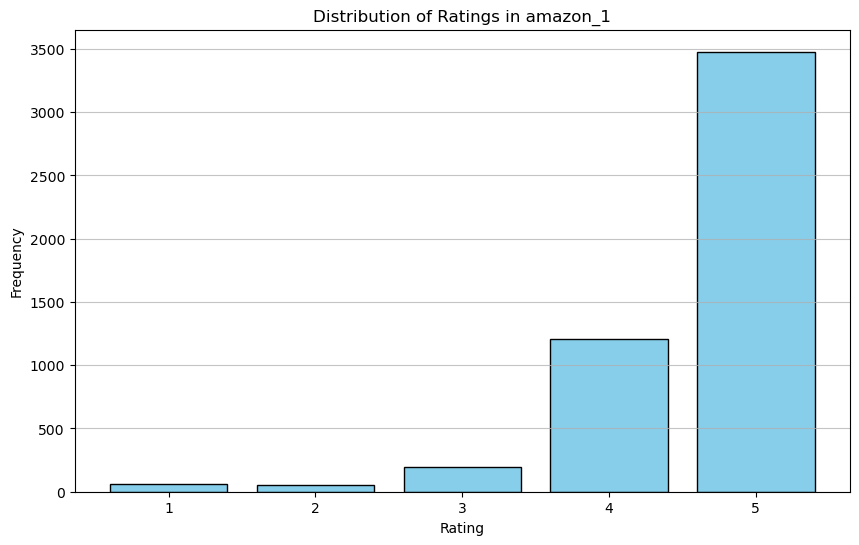

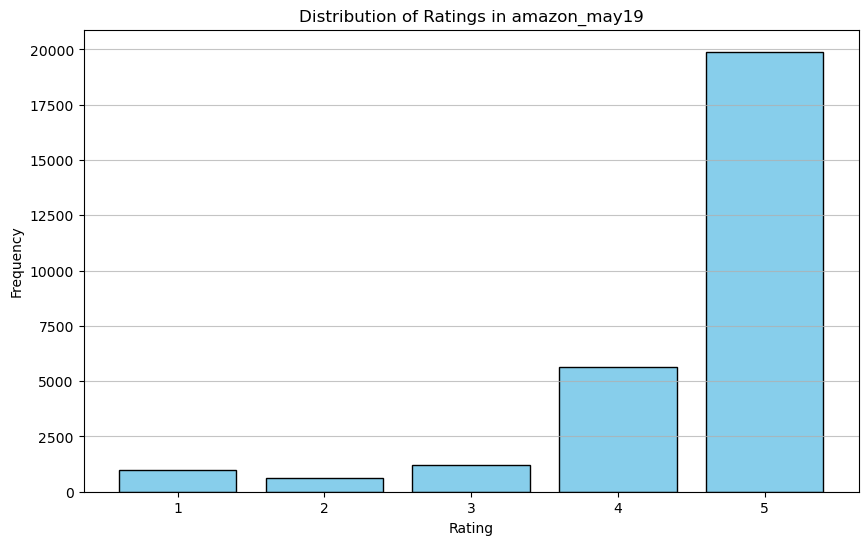

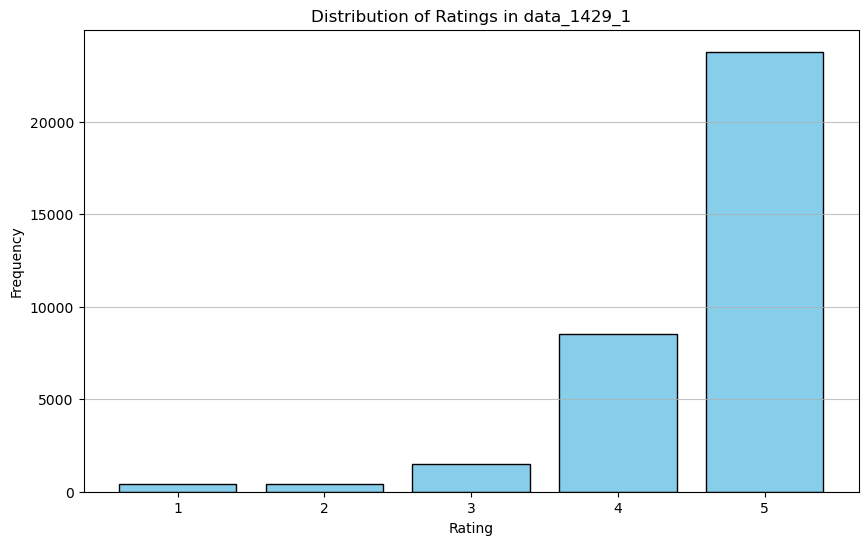

In [4]:
def plot_rating_distributions(datasets):
    '''Plot histograms of rating distributions for multiple datasets.'''
    for name, df in datasets.items():
        if "reviews.rating" in df.columns:
            plt.figure(figsize=(10, 6))
            df_clean = df.dropna(subset=["reviews.rating"])
            plt.hist(
                df_clean["reviews.rating"],
                bins=range(1, 7),
                align="left",
                rwidth=0.8,
                color="skyblue",
                edgecolor="black",
            )
            plt.title(f"Distribution of Ratings in {name}")
            plt.xlabel("Rating")
            plt.ylabel("Frequency")
            plt.xticks(range(1, 6))
            plt.grid(axis="y", alpha=0.75)
            plt.show()

datasets = {
    "amazon_1": datafiniti_amazon_1,
    "amazon_may19": datafiniti_amazon_may19,
    "data_1429_1": data_1429_1,
}
plot_rating_distributions(datasets)

## Data Merging - Step 1

In [5]:
df1_pre = datafiniti_amazon_1.copy()
df2_pre = datafiniti_amazon_may19.copy()

DROP_COLS = ["reviews.dateAdded"]
df1_pre = df1_pre.drop(columns=[c for c in DROP_COLS if c in df1_pre.columns], errors="ignore")
df2_pre = df2_pre.drop(columns=[c for c in DROP_COLS if c in df2_pre.columns], errors="ignore")

df1_pre = df1_pre.loc[:, ~df1_pre.columns.duplicated()]
df2_pre = df2_pre.loc[:, ~df2_pre.columns.duplicated()]

datafiniti_amazon_pre = pd.concat([df1_pre, df2_pre], ignore_index=True).drop_duplicates()

## Data Merging - Step 2

In [6]:
df1 = datafiniti_amazon_pre.copy()
df2 = data_1429_1.copy()

df1 = df1.rename(columns={"primaryCategories": "categories"})

DROP_COLS = [
    "reviews.didPurchase", "reviews.id", "reviews.userCity", "reviews.userProvince",
    "imageURLs", "dateAdded", "dateUpdated", "manufacturerNumber", "sourceURLs",
]
df1 = df1.drop(columns=[c for c in DROP_COLS if c in df1.columns], errors="ignore")
df2 = df2.drop(columns=[c for c in DROP_COLS if c in df2.columns], errors="ignore")

df1 = df1.loc[:, ~df1.columns.duplicated()]
df2 = df2.loc[:, ~df2.columns.duplicated()]

if "reviews.doRecommend" in df1.columns:
    df1["reviews.doRecommend"] = (
        df1["reviews.doRecommend"]
        .map({"TRUE": True, "FALSE": False, "true": True, "false": False,
              "True": True, "False": False, None: None})
        .astype("boolean")
    )

if "reviews.doRecommend" in df2.columns:
    df2["reviews.doRecommend"] = df2["reviews.doRecommend"].astype("boolean", errors="ignore")

if "reviews.numHelpful" in df1.columns:
    df1["reviews.numHelpful"] = (
        pd.to_numeric(df1["reviews.numHelpful"], errors="coerce").fillna(0).astype(int)
    )

COMMON_COLS = list(df1.columns.intersection(df2.columns))
for col in COMMON_COLS:
    if df1[col].dtype != df2[col].dtype:
        df1[col] = pd.to_numeric(df1[col], errors="coerce").fillna(pd.NA)
        df2[col] = pd.to_numeric(df2[col], errors="coerce").fillna(pd.NA)

datafiniti_amazon = pd.concat([df1, df2], ignore_index=True).drop_duplicates()

## Missing Values

In [7]:
missing_values = datafiniti_amazon.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

total_rows = len(datafiniti_amazon)
missing_percentage = (missing_values / total_rows) * 100
print("\nMissing values percentage per column:\n", missing_percentage[missing_percentage > 0])

Missing values per column:
 name                    6760
asins                      2
reviews.date              39
reviews.doRecommend    33285
reviews.numHelpful       529
reviews.rating            33
reviews.text               1
reviews.title             19
reviews.username          12
reviews.dateAdded      43312
dtype: int64

Missing values percentage per column:
 name                   10.036970
asins                   0.002970
reviews.date            0.057906
reviews.doRecommend    49.420202
reviews.numHelpful      0.785437
reviews.rating          0.048997
reviews.text            0.001485
reviews.title           0.028210
reviews.username        0.017817
reviews.dateAdded      64.307880
dtype: float64


## Handle Missing Values

In [8]:
if "name" in datafiniti_amazon.columns:
    datafiniti_amazon["name"] = datafiniti_amazon["name"].fillna("Anon")

if "reviews.doRecommend" in datafiniti_amazon.columns:
    datafiniti_amazon["reviews.doRecommend"] = datafiniti_amazon["reviews.doRecommend"].fillna(False)

if "reviews.dateAdded" in datafiniti_amazon.columns:
    datafiniti_amazon = datafiniti_amazon.drop(columns=["reviews.dateAdded"])

if "asins" in datafiniti_amazon.columns:
    datafiniti_amazon["asins"] = datafiniti_amazon["asins"].fillna("Unknown")

if "reviews.date" in datafiniti_amazon.columns:
    datafiniti_amazon["reviews.date"] = pd.to_datetime(datafiniti_amazon["reviews.date"], errors="coerce")
    median_date = datafiniti_amazon["reviews.date"].median()
    datafiniti_amazon["reviews.date"] = datafiniti_amazon["reviews.date"].fillna(median_date)

if "reviews.numHelpful" in datafiniti_amazon.columns:
    datafiniti_amazon["reviews.numHelpful"] = datafiniti_amazon["reviews.numHelpful"].fillna(0)

datafiniti_amazon = datafiniti_amazon.dropna(subset=["reviews.rating", "reviews.text"])

if "reviews.title" in datafiniti_amazon.columns:
    datafiniti_amazon = datafiniti_amazon.rename(columns={"reviews.title": "title"})
    datafiniti_amazon["title"] = datafiniti_amazon["title"].fillna("title")

if "reviews.username" in datafiniti_amazon.columns:
    datafiniti_amazon["reviews.username"] = datafiniti_amazon["reviews.username"].fillna("Anon")

## Column Renaming

In [9]:
datafiniti_amazon = datafiniti_amazon.rename(
    columns={col: col.replace("reviews.", "") for col in datafiniti_amazon.columns}
)

## Sentiment Mapping

In [10]:
if "rating" in datafiniti_amazon.columns:
    def map_rating_to_sentiment(rating):
        if rating >= 4:
            return "Positive"
        if rating == 3:
            return "Neutral"
        return "Negative"

    datafiniti_amazon["star_sentiment"] = datafiniti_amazon["rating"].apply(map_rating_to_sentiment)

## Trustworthiness Column

In [11]:
if "doRecommend" in datafiniti_amazon.columns and "star_sentiment" in datafiniti_amazon.columns:
    def determine_trustworthy(row):
        sentiment = row["star_sentiment"]
        recommend = row["doRecommend"]
        if sentiment == "Positive":
            return recommend
        if sentiment == "Neutral":
            return True
        if sentiment == "Negative":
            return not recommend
        return None

    datafiniti_amazon["trustworthy"] = datafiniti_amazon.apply(determine_trustworthy, axis=1)

In [12]:
datafiniti_amazon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67317 entries, 0 to 67896
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              67317 non-null  object             
 1   name            67317 non-null  object             
 2   asins           67317 non-null  object             
 3   brand           67317 non-null  object             
 4   categories      67317 non-null  object             
 5   keys            67317 non-null  object             
 6   manufacturer    67317 non-null  object             
 7   date            67317 non-null  datetime64[ns, UTC]
 8   dateSeen        67317 non-null  object             
 9   doRecommend     67317 non-null  boolean            
 10  numHelpful      67317 non-null  float64            
 11  rating          67317 non-null  float64            
 12  sourceURLs      67317 non-null  object             
 13  text            67317 non-null  obje

## Data Visualizations

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 12))

if "star_sentiment" in datafiniti_amazon.columns:
    plt.subplot(2, 2, 1)
    sns.countplot(x="star_sentiment", data=datafiniti_amazon,
                  palette="viridis", hue="trustworthy", legend=False)
    plt.title("Distribution of Sentiment")

if "name" in datafiniti_amazon.columns:
    plt.subplot(2, 2, 2)
    top_products = datafiniti_amazon["name"].value_counts().nlargest(10)
    sns.barplot(x=top_products.values, y=top_products.index, palette="magma", legend=False)
    plt.title("Top 10 Products by Number of Reviews")

if "doRecommend" in datafiniti_amazon.columns:
    plt.subplot(2, 2, 3)
    sns.countplot(x="doRecommend", data=datafiniti_amazon,
                  palette="cividis", legend=False)
    plt.title("Distribution of Recommendation")

if "date" in datafiniti_amazon.columns:
    plt.subplot(2, 2, 4)
    datafiniti_amazon["date"] = pd.to_datetime(datafiniti_amazon["date"], errors="coerce")
    reviews_over_time = datafiniti_amazon.set_index("date").resample("ME").size()
    reviews_over_time.plot(kind="line", marker="o", linestyle="-", color="skyblue")
    plt.title("Number of Reviews Over Time")

plt.tight_layout()
plt.show()

## Save Cleaned Data

In [ ]:
OUTPUT_FILE = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_cleaned.csv"
OUTPUT_PATH = os.path.join(SCRIPT_DIR, "../data/processed/", OUTPUT_FILE)
datafiniti_amazon.to_csv(OUTPUT_PATH, index=False)